**Import**

In [19]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm
from skimage.filters import threshold_otsu, threshold_sauvola
from skimage.morphology import closing, disk, remove_small_objects
from sklearn.metrics import jaccard_score


In [20]:
# --- CONFIGURATION ---
IMAGE_DIR = "images/"
MASK_DIR = "masks/"

**Metrics**

In [21]:
def dice_score(y_true, y_pred):
    y_true = y_true.flatten()
    y_pred = y_pred.flatten()
    
    intersection = np.sum(y_true * y_pred)
    return (2. * intersection) / (np.sum(y_true) + np.sum(y_pred) + 1e-8)


In [22]:
def jaccard_index(y_true, y_pred):
    return jaccard_score(y_true.flatten(), y_pred.flatten())

**Preprocessing and Postprocessing**

In [23]:
def preprocess(img):

    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # contrast normalization
    gray = cv2.normalize(gray, None, 0, 255, cv2.NORM_MINMAX)

    # CLAHE improves MRI contrast
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    gray = clahe.apply(gray)

    gray = cv2.GaussianBlur(gray, (5,5), 0)

    return gray


In [ ]:
def extract_brain_region(img):

    t = threshold_otsu(img)
    mask = img > t

    mask = closing(mask, disk(5))
    mask = remove_small_objects(mask, max_size=5000)

    # keep largest connected component only
    labels = cv2.connectedComponents(mask.astype(np.uint8))[1]
    largest = labels == np.argmax(np.bincount(labels.flat)[1:]) + 1

    return largest.astype(np.uint8)


In [25]:
def keep_best_component(mask, min_size=50, max_size=5000):

    num, labels = cv2.connectedComponents(mask.astype(np.uint8))

    best = np.zeros_like(mask)

    for i in range(1, num):

        comp = (labels == i)
        area = np.sum(comp)

        if min_size < area < max_size:
            best = best | comp

    return best.astype(np.uint8)


In [26]:
def otsu_segmentation(img):

    brain = extract_brain_region(img)

    roi = img * brain

    # only use high-intensity pixels
    p90 = np.percentile(roi[brain==1], 90)

    tumor = roi > p90

    tumor = closing(tumor, disk(2))
    tumor = keep_best_component(tumor)

    return tumor


In [27]:
def sauvola_segmentation(img):

    brain = extract_brain_region(img)

    thresh = threshold_sauvola(img, window_size=25, k=0.15)

    local = img > thresh

    # add brightness filter
    bright = img > np.percentile(img[brain==1], 85)

    tumor = local & bright & brain

    tumor = closing(tumor, disk(2))
    tumor = keep_best_component(tumor)

    return tumor


In [28]:
image_files = sorted(os.listdir(IMAGE_DIR))
mask_files  = sorted(os.listdir(MASK_DIR))

pairs = list(zip(image_files, mask_files))
len(pairs)


3064

In [29]:
dice_otsu = []
dice_sauvola = []

jac_otsu = []
jac_sauvola = []


**Main loop**

In [30]:
for img_name, mask_name in tqdm(pairs):

    img_path  = os.path.join(IMAGE_DIR, img_name)
    mask_path = os.path.join(MASK_DIR, mask_name)

    img  = cv2.imread(img_path)
    mask = cv2.imread(mask_path, 0)

    if img is None or mask is None:
        continue

    img_p = preprocess(img)

    mask = (mask > 127).astype(np.uint8)

    # skip slices without tumor (important for fair Dice)
    if np.sum(mask) == 0:
        continue

    otsu_mask = otsu_segmentation(img_p)
    sau_mask  = sauvola_segmentation(img_p)

    dice_otsu.append(dice_score(mask, otsu_mask))
    dice_sauvola.append(dice_score(mask, sau_mask))

    jac_otsu.append(jaccard_index(mask, otsu_mask))
    jac_sauvola.append(jaccard_index(mask, sau_mask))


  0%|          | 0/3064 [00:00<?, ?it/s]C:\Users\rahul\AppData\Local\Temp\ipykernel_19244\2424744834.py:7: FutureWarning: Parameter `min_size` is deprecated since version 0.26.0 and will be removed in 2.0.0 (or later). To avoid this warning, please use the parameter `max_size` instead. For more details, see the documentation of `remove_small_objects`. Note that the new threshold removes objects smaller than **or equal to** its value, while the previous parameter only removed smaller ones.
  mask = remove_small_objects(mask, 5000)
  0%|          | 1/3064 [00:00<16:01,  3.18it/s]C:\Users\rahul\AppData\Local\Temp\ipykernel_19244\2424744834.py:7: FutureWarning: Parameter `min_size` is deprecated since version 0.26.0 and will be removed in 2.0.0 (or later). To avoid this warning, please use the parameter `max_size` instead. For more details, see the documentation of `remove_small_objects`. Note that the new threshold removes objects smaller than **or equal to** its value, while the previous

**Results**

In [31]:
print("===== RESULTS =====")

print("\nOtsu Thresholding")
print("Dice     :", np.mean(dice_otsu))
print("Jaccard  :", np.mean(jac_otsu))

print("\nSauvola Thresholding")
print("Dice     :", np.mean(dice_sauvola))
print("Jaccard  :", np.mean(jac_sauvola))


===== RESULTS =====

Otsu Thresholding
Dice     : 0.08942317302730271
Jaccard  : 0.05062177387783899

Sauvola Thresholding
Dice     : 0.13646872808971086
Jaccard  : 0.08018595248556093


In [32]:
def show_sample(i):

    img = cv2.imread(os.path.join(IMAGE_DIR, image_files[i]))
    mask = cv2.imread(os.path.join(MASK_DIR, mask_files[i]), 0)

    img_p = preprocess(img)

    otsu_m = otsu_segmentation(img_p)
    sau_m  = sauvola_segmentation(img_p)

    plt.figure(figsize=(12,4))

    plt.subplot(1,4,1)
    plt.imshow(img_p, cmap='gray')
    plt.title("MRI")

    plt.subplot(1,4,2)
    plt.imshow(mask, cmap='gray')
    plt.title("Ground Truth")

    plt.subplot(1,4,3)
    plt.imshow(otsu_m, cmap='gray')
    plt.title("Otsu")

    plt.subplot(1,4,4)
    plt.imshow(sau_m, cmap='gray')
    plt.title("Sauvola")

    plt.show()


C:\Users\rahul\AppData\Local\Temp\ipykernel_19244\2424744834.py:7: FutureWarning: Parameter `min_size` is deprecated since version 0.26.0 and will be removed in 2.0.0 (or later). To avoid this warning, please use the parameter `max_size` instead. For more details, see the documentation of `remove_small_objects`. Note that the new threshold removes objects smaller than **or equal to** its value, while the previous parameter only removed smaller ones.
  mask = remove_small_objects(mask, 5000)


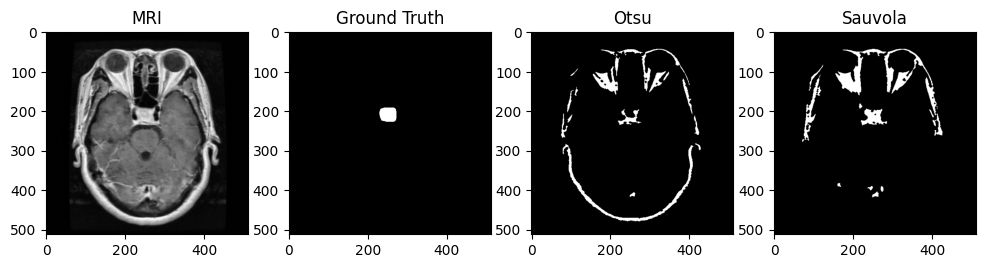

In [33]:
show_sample(10)